# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Цель работы:** построить модель, предсказывающую температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Обзор данных

Импортируем необходимые в работе библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

Изучим предоставленные файлы. Напишем функции для открытия и изучения файлов.

In [2]:
#функция для чтения файлов
def read_file(name):
    return pd.read_csv(file_path + name + '.csv')

In [3]:
#функция для обзора данных: первые 10 строк таблицы, информация, описательные характеристики,
#пропуски, дубликаты
def data_info(data):
    display(data.head(10))
    print('--------------------------')
    print(data.info())
    print('--------------------------')
    display(data.describe())
    print('--------------------------')
    print('Количество пропусков:\n', data.isna().sum())
    print('--------------------------')
    print('Количество дубликатов:', data.duplicated().sum())

* Данные об электродах

In [4]:
file_path = '/datasets/final_steel/'

data_arc = read_file('data_arc')
data_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
--------------------------


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


--------------------------
Количество пропусков:
 key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
--------------------------
Количество дубликатов: 0


* Нужно преобразовать начало и конец нагрева дугой к типу datetime;
* В столбце с реактивной мощностью присутствуют значительные выбросы с отрицательными значениями;
* Пропуски и дубликаты отстутствуют;
* Следует вычислить значение полной мощности и длительность нагрева.

* Данные о подаче сыпучих материалов (объём)

In [5]:
data_bulk = read_file('data_bulk')
data_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
--------------------------


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


--------------------------
Количество пропусков:
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
--------------------------
Количество дубликатов: 0


В таблице присутствует большое количество пропусков, которые, скорее всего, означают, что какой-то из материалов для данной партии не добавлялся, соответственно, пропуски можно заменить на 0.

* Данные о подаче сыпучих материалов (время)

In [6]:
data_bulk_time = read_file('data_bulk_time')
data_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
--------------------------


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


--------------------------
Количество пропусков:
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
--------------------------
Количество дубликатов: 0


В данной таблице находится информация о дате и времени добавления сыпучих материалов. На предсказание температуры стали эта информация вряд ли будет влиять.

* Данные о продувке сплава газом

In [7]:
data_gas = read_file('data_gas')
data_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
--------------------------


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


--------------------------
Количество пропусков:
 key      0
Газ 1    0
dtype: int64
--------------------------
Количество дубликатов: 0


Пропусков и дубликатов в данных не наблюдается, значительных выбросов тоже.

* Результаты измерения температуры

In [8]:
data_temp = read_file('data_temp')
data_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
--------------------------


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


--------------------------
Количество пропусков:
 key                0
Время замера       0
Температура     2901
dtype: int64
--------------------------
Количество дубликатов: 0


Присутствуют пропуски в столбце с температурой, выясним с чем это связано при дальнейшем анализе. Также можно привести столбец со временем замера к типу datetime.

* Данные о проволочных материалах (объём)

In [9]:
data_wire = read_file('data_wire')
data_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
--------------------------


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


--------------------------
Количество пропусков:
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
--------------------------
Количество дубликатов: 0


Как и в таблице с сыпучими материалами, пропуски заменим нулями.

* Данные о проволочных материалах (время)

In [10]:
data_wire_time = read_file('data_wire_time')
data_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
--------------------------


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


--------------------------
Количество пропусков:
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
--------------------------
Количество дубликатов: 0


Аналогично ситуации с сыпучими материалами, информация о времени нам не важна.

### Вывод

* В таблице с данными об электродах нужно преобразовать начало и конец нагрева дугой к типу datetime, а в столбце с реактивной мощностью присутствуют значительные выбросы с отрицательными значениями. Также нужно вычислить значение полной мощности и длительность нагрева и добавить их в качестве признаков.
* В таблицах с данными об объемах сыпучих материалов и проволочных материалов решено заменить пропуски на нули.
* Данные из таблиц о времени подачи сыпучих материалов и проволочных материалов не важны для дальнейшего моделирования.
* В таблице с результатами измерения температуры есть пропуски в столбце с температурой, при дальнейшем анализе выясним причину, и исследуем температуру на наличие выбросов и аномальных значений. Также приведем столбец со временем замера к типу datetime. 

## Предобработка данных

### Замена типов данных

In [11]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(
    data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S'
)
data_arc['Конец нагрева дугой'] = pd.to_datetime(
    data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S'
)
data_temp['Время замера'] = pd.to_datetime(
    data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S'
)

### Обработка пропусков

В таблицах с данными о сыпучих материалах и о проволочных материалах заменим пропуски на 0.

In [12]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

Теперь разберемся с пропусками в результатах измерения температуры. Логично, что если в целевом признаке (в последнем измерении температуры) находится пропуск, то такую партию следует удалить, потому что ценности для модели она представлять не будет. Посчитаем, сколько всего партий, в которых присутствуют пропуски в измерении температуры, и сколько партий, в которых пропущено значение последнего измерения температуры.

In [13]:
keys = data_temp[data_temp['Температура'].isna()]['key'].unique()
print('Количество партий с пропусками', keys.shape[0])
count = 0
for k in keys:
    data = data_temp[data_temp['key'] == k]
    if np.isnan(data.loc[data.index.max(), 'Температура']):
        count += 1
print('Количество партий с пропусками в целевом признаке', count)

Количество партий с пропусками 739
Количество партий с пропусками в целевом признаке 739


Все партии с пропусками - это те партии, в которых есть пропуск в целевом признаке, следовательно, удалим данные об этих партиях из таблицы.

In [14]:
for k in keys:
    data_temp.drop(data_temp[data_temp['key']==k].index, inplace=True)

In [15]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


### Рассчеты и добавление результатов в таблицу

Посчитаем для таблицы `data_arc` полную мощность и длительность нагрева и добавим результаты в таблицу.

In [16]:
#функция для вычисления полной мощности
def power_calc(row):
    return ((row['Активная мощность'])**2 + (row['Реактивная мощность'])**2)**0.5

In [17]:
#функция для вычисления длительности нагрева
def time_calc(row):
    return (row['Конец нагрева дугой'] -  row['Начало нагрева дугой']).seconds

In [18]:
data_arc['Полная мощность'] = data_arc.apply(power_calc, axis=1)
data_arc['Длительность нагрева'] = data_arc.apply(time_calc, axis=1)
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Длительность нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148


### Вывод

На данном этапе:
* Были приведены типы данных начала и конца нагрева дугой и временем замера температуры к типу datetime;
* В таблицах с данными о сыпучих материалах и о проволочных материалах заменены пропуски на нули;
* Выяснено, что партии с пропусками в данных о замерах температур - это партии с пропусками в целевом признаке, данные о таких партиях были удалены;
* Для таблицы с данными об электродах были посчитаны полная мощность и длительность нагрева.

## Исследовательский анализ данных

### Поиск выбросов и аномалий

При обзоре данных подозрение на наличие сильных выбросов возникло только для данных об электродах. Таблицу с целевым признаком тоже было бы неплохо проверить на наличие выбросов. Проверим данные об электродах и о температуре на наличие выбросов и аномалий, для этого построим диаграммы размаха.

* Данные об электродах

Text(0.5, 1.0, 'Реактивная мощность')

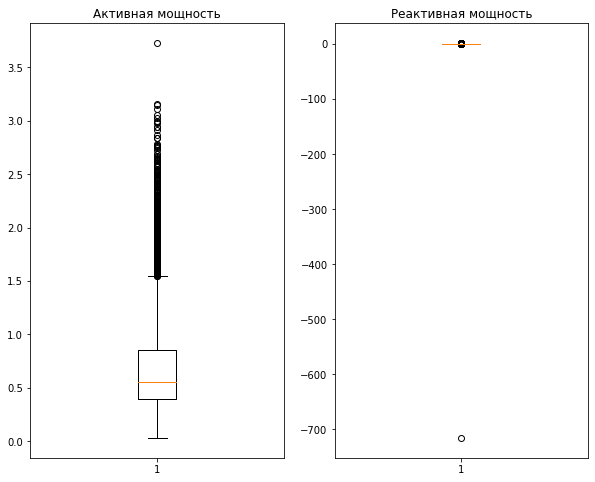

In [19]:
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.boxplot(data_arc['Активная мощность'])
plt.title('Активная мощность')
plt.subplot(122)
plt.boxplot(data_arc['Реактивная мощность'])
plt.title('Реактивная мощность')

Виден один сильный выброс в реактивной мощности (значение около -700), удалим данные об этой партии из таблицы.

In [20]:
data_arc = data_arc[data_arc['Реактивная мощность'] > -700]

Снова посмотрим на диаграммы размаха.

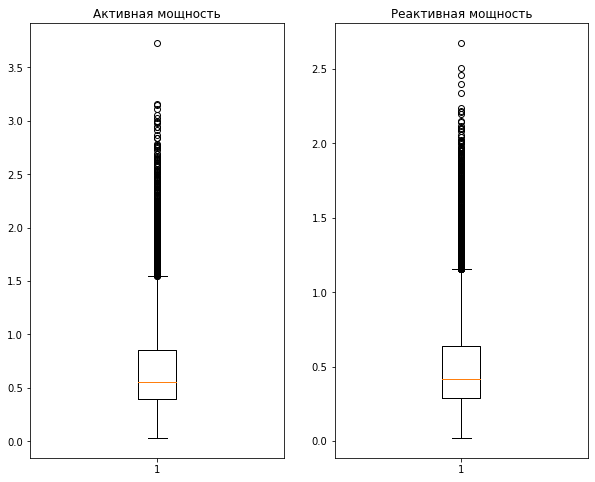

In [21]:
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.boxplot(data_arc['Активная мощность'])
plt.title('Активная мощность')
plt.subplot(122)
plt.boxplot(data_arc['Реактивная мощность'])
plt.title('Реактивная мощность');

Присутствуют выбросы в большую сторону, но они не значительные, потому обрабатывать их не будем.

* Результаты измерения температуры

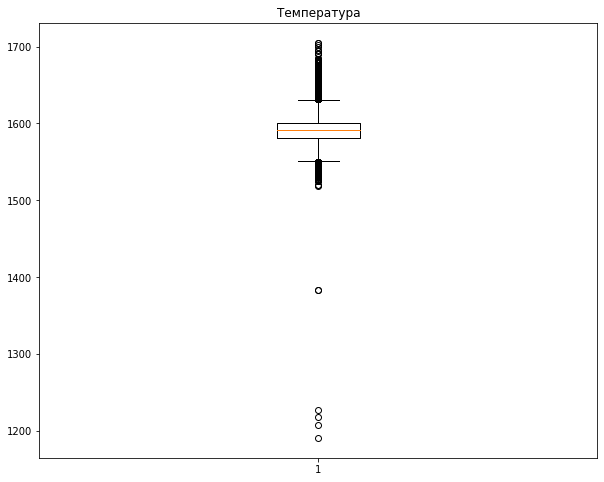

In [22]:
plt.figure(figsize=(10, 8))
plt.boxplot(data_temp['Температура'])
plt.title('Температура');

Есть несколько значений температуры менее 1400. Посмортим, что это за партии.

In [23]:
data_temp[data_temp['Температура'] < 1400]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0


Посмотрим, как менялась температура для этих партий.

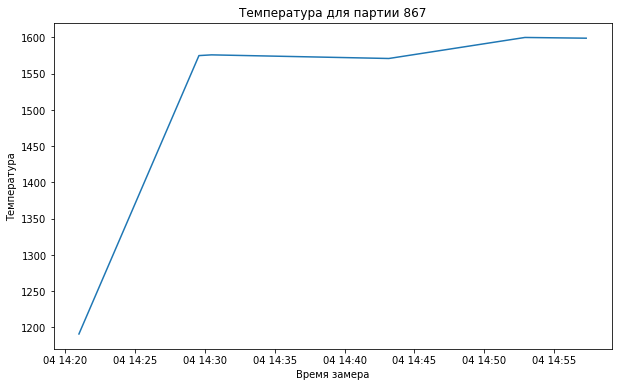

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(data_temp[data_temp['key']==867]['Время замера'], 
         data_temp[data_temp['key']==867]['Температура'])
plt.title('Температура для партии 867')
plt.ylabel('Температура')
plt.xlabel('Время замера');

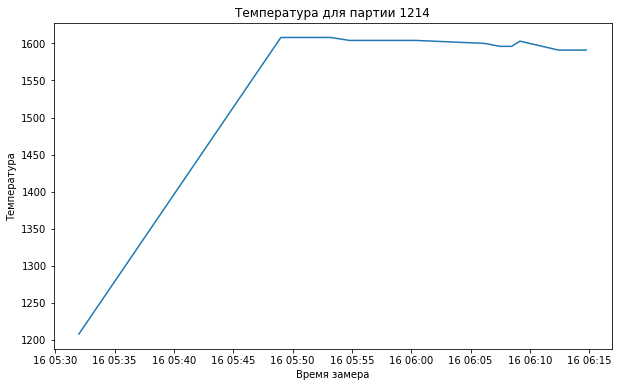

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(data_temp[data_temp['key']==1214]['Время замера'], 
         data_temp[data_temp['key']==1214]['Температура'])
plt.title('Температура для партии 1214')
plt.ylabel('Температура')
plt.xlabel('Время замера');

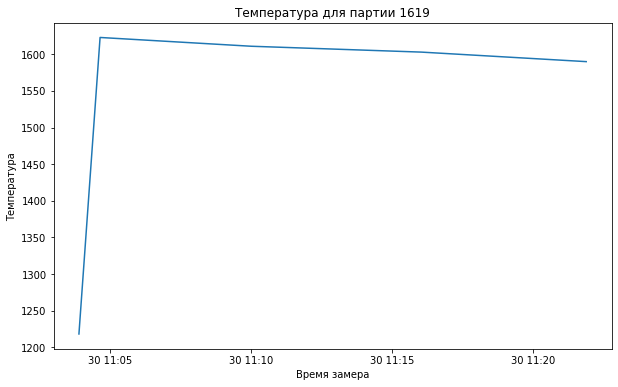

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(data_temp[data_temp['key']==1619]['Время замера'], 
         data_temp[data_temp['key']==1619]['Температура'])
plt.title('Температура для партии 1619')
plt.ylabel('Температура')
plt.xlabel('Время замера');

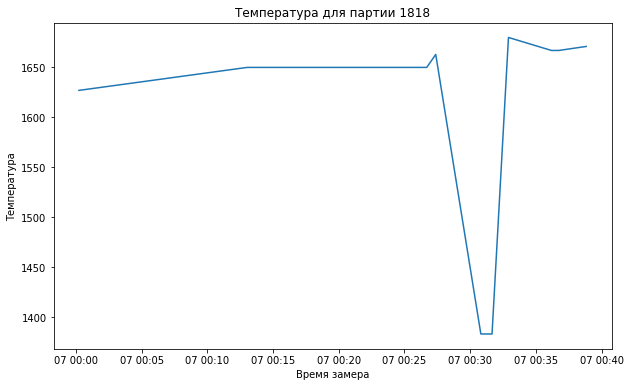

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(data_temp[data_temp['key']==1818]['Время замера'], 
         data_temp[data_temp['key']==1818]['Температура'])
plt.title('Температура для партии 1818')
plt.ylabel('Температура')
plt.xlabel('Время замера');

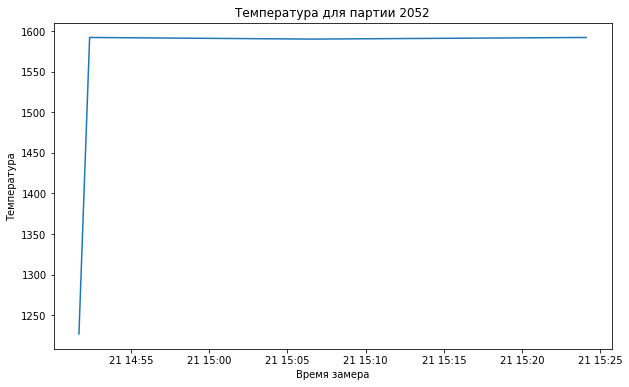

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(data_temp[data_temp['key']==2052]['Время замера'], 
         data_temp[data_temp['key']==2052]['Температура'])
plt.title('Температура для партии 2052')
plt.ylabel('Температура')
plt.xlabel('Время замера');

В основном, в рассмотренных партиях с относительно небольшой температуры начинается процесс обработки, скорее всего, это связано с какими-то особенностями конкретной партии, но скорее всего это ошибка в измерении. Для партии 1818 присутствует странный скачок температуры в 200 градусов, скорее всего, это какая-то ошибка при измерении. Удалим эти партии из выборки. 

In [29]:
keys = [687, 1214, 1619, 1818, 2052]
for k in keys:
    data_temp.drop(data_temp[data_temp['key']==k].index, inplace=True)
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


### Анализ добавленных материалов

Посмотрим, какие из сыпучих и проволочных материалов чаще всего добавляются для корректировки химического состава.

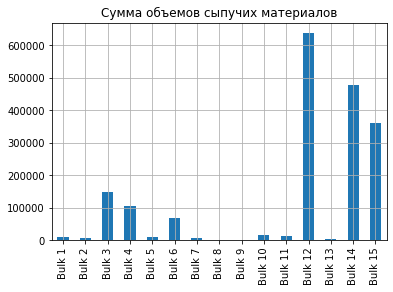

In [30]:
data_bulk.drop('key', axis=1).sum().plot(kind='bar', grid=True, title='Сумма объемов сыпучих материалов');

Больше всего добавляются материалы bulk 12, bulk 14, bulk 15, меньше всего - bulk 8 и bulk 9.

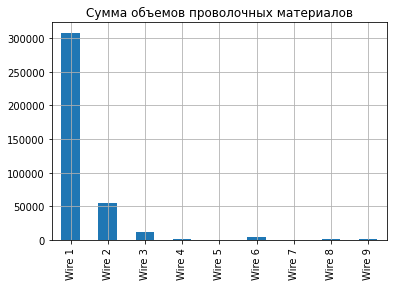

In [31]:
data_wire.drop('key', axis=1).sum().plot(kind='bar', grid=True, title='Сумма объемов проволочных материалов');

Больше всего добавляется материал wire 1, меньше всего - wire 4-9.

### Объединение таблиц

Прежде чем посмотреть, как признаки коррелируют между собой, выделим нужные признаки и объединим их в одну таблицу. Из таблицы с данными об электродах возьмем созданные столбцы с полной мощностью и временем и длительностью нагрева и добавим их медианные значения по партиям. Данные об объеме сыпучих материалов и проволочных материалов добавим полностью, а вот время вряд ли будет важным признаком. Также полностью присоединим данные о продувке сплава газом. Из таблицы с результатами измерения температуры нужно выделить целевой признак - последнее измерение температуры, а также добавим в качестве признака первое измерение температуры для каждой партии.

Выделим первое и последнее измерение температуры в каждой партии.

In [33]:
data_temp_start = data_temp[['key', 'Температура']].groupby(['key'], as_index=False).head(1)
data_temp_start = data_temp_start.rename(columns={'Температура':'Начальная температура'})
data_temp_start.head()

,key,Начальная температура
0,1,1571.0
5,2,1581.0
11,3,1596.0
16,4,1601.0
19,5,1576.0


In [34]:
data_temp_final = data_temp[['key', 'Температура']].groupby(['key'], as_index=False).tail(1)
data_temp_final = data_temp_final.rename(columns={'Температура':'Конечная температура'})
data_temp_final.head()

,key,Конечная температура
4,1,1613.0
10,2,1602.0
15,3,1599.0
18,4,1625.0
20,5,1602.0


Объединим таблицы.

In [35]:
data_final = data_temp_start.copy()
data_final = data_final.merge(data_temp_final, on='key')
data_final = data_final.merge(data_arc.groupby('key')['Полная мощность'].sum(), on='key')
data_final = data_final.merge(data_arc.groupby('key')['Длительность нагрева'].median(), on='key')
data_final = data_final.merge(data_bulk, on='key')
data_final = data_final.merge(data_gas, on='key')
data_final = data_final.merge(data_wire, on='key')
data_final = data_final.drop('key', axis=1)
data_final.head(10)

,Начальная температура,Конечная температура,Полная мощность,Длительность нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,5.826395,185.0,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,3.649216,173.5,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,2.989534,109.0,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,3.814962,182.0,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,4.035758,191.5,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1543.0,1596.0,4.786837,225.5,0.0,0.0,0.0,117.0,0.0,0.0,...,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1586.0,1599.0,2.987777,108.5,0.0,0.0,0.0,117.0,0.0,0.0,...,9.836267,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1577.0,1598.0,4.627389,205.5,0.0,0.0,0.0,99.0,0.0,0.0,...,15.171553,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1587.0,1592.0,2.555348,156.0,0.0,0.0,0.0,117.0,0.0,0.0,...,8.216623,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1574.0,1593.0,3.851739,117.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.529891,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
data_final

,Начальная температура,Конечная температура,Полная мощность,Длительность нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,5.826395,185.0,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,3.649216,173.5,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,2.989534,109.0,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,3.814962,182.0,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,4.035758,191.5,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,1570.0,1591.0,3.986869,195.0,0.0,0.0,21.0,0.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,1554.0,1591.0,5.057033,139.0,0.0,0.0,0.0,63.0,0.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,1571.0,1589.0,2.885017,206.0,0.0,0.0,0.0,85.0,0.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,1591.0,1594.0,4.143749,133.0,0.0,0.0,90.0,0.0,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Корреляция признаков

Посмотрим, как признаки коррелируют между собой, построим тепловую карту коэффициентов корреляции Пирсона.

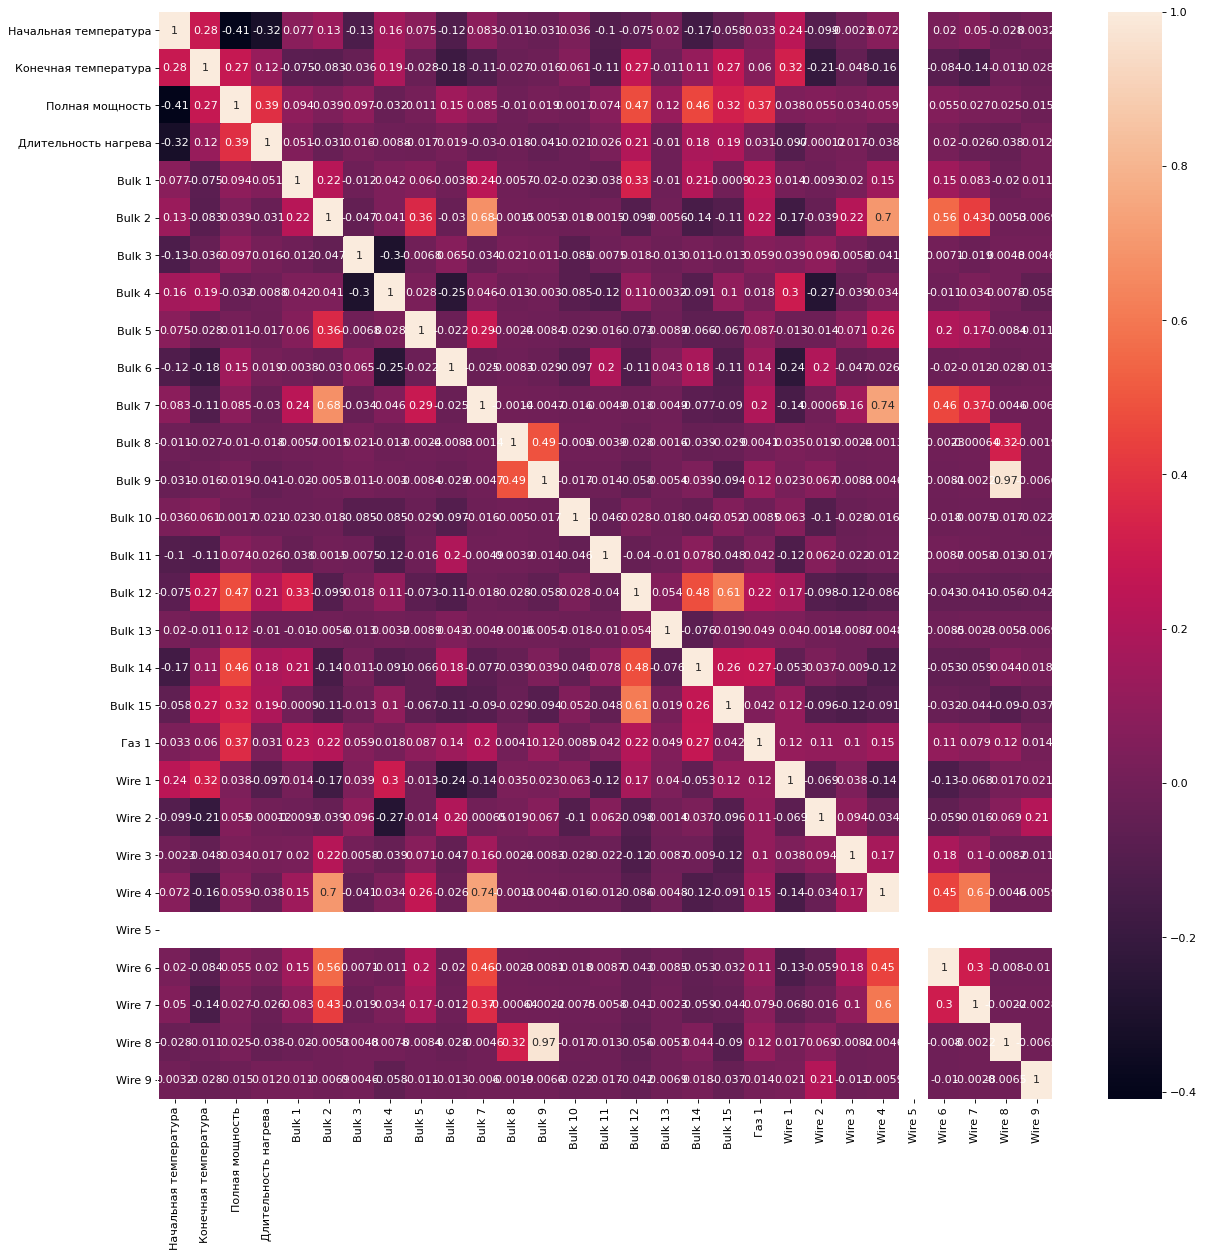

In [37]:
plt.figure(figsize=(18,18), dpi=80)
sns.heatmap(data_final.corr(method='pearson'), annot=True);

Наблюдается очень высокая корреляция между полной мощностью и длительностью нагрева, а также между `Bulk 9` и `Wire 8`. Удалим из общей таблицы по одному признаку из пары, в нашем случае это будут длительность нагрева и bulk 9, также удалим wire 5, так как он нулевой. Также наблюдается высокая корреляция между `Wire 4` и `Bulk 2` и между `Wire 4` и `Bulk 7` и средняя корреляция между `Wire 4` и `Wire 7`, `Bulk 15` и `Bulk 12`, `Wire 6` и `Bulk 2`, `Bulk 2` и `Bulk 7`. Между остальными признаками корреляция слабая, а с целевым признаком все остальные признаки коррелируют очень слабо.

In [38]:
data_final = data_final.drop(['Длительность нагрева', 'Bulk 9', 'Wire 5'], axis=1)
data_final.head()

,Начальная температура,Конечная температура,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,5.826395,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,3.649216,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,2.989534,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,3.814962,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,4.035758,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


### Вывод

На данном этапе:
* Был проведено исследование на наличие выбросов и аномалий таблиц с данными об электродах и результатами измерения температур, были обнаружены и удалены партии с сильными выбросами в реактивной мощности и температуре;
* Проведен анализ добавляемых материалов, из сыпучих материалов больше всего добавляются материалы bulk 12, bulk 14, bulk 15, меньше всего - bulk 8 и bulk 9, из проволочных материалов больше всего добавляется материал wire 1, меньше всего - wire 4-9;
* Все важные признаки были объединены в одной таблице и было выяснено, как признаки коррелируют между собой. Была обнаружена очень высокая корреляция между полной мощностью и длительностью нагрева, а также между Bulk 9 и Wire 8, длительность нагрева и Bulk 9 были удалены из финальной таблицы. Также есть высокая корреляция между Wire 4 и Bulk 2 и между Wire 4 и Bulk 7 и средняя корреляция между Wire 4 и Wire 7, Bulk 15 и Bulk 12, Wire 6 и Bulk 2, Bulk 2 и Bulk 7. Между остальными признаками корреляция слабая, с целевым признаком все остальные признаки коррелируют очень слабо.

**Примерный план решения задачи:**
1. Обзор данных, их подготовка и анализ, разделение данных на обучающую и тестовую выборки.
2. Обучение моделей. Для данной задачи рассмотрим такие модели: дерево решений, случайный лес, линейная регрессия, CatBoost. Лучшие параметры будем подбирать при помощи RandomizedSearchCV, метрика - MAE.
3. Выбор лучшей модели и ее проверка на тестовой выборке.
4. Анализ важности факторов для лучшей модели, выводы.

## Обучение моделей

### Формирование обучающей и тестовой выборок

Разделим выборку на обучающую и тестовую выборки.

In [40]:
#деление на признаки и целевой признак
X = data_final.drop(['Конечная температура'], axis=1)
y = data_final['Конечная температура']

#деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=31102022)

#проверяем размеры выборок
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1743, 25) (1743,)
(582, 25) (582,)


In [41]:
1743+582

2325

In [42]:
X.head()

,Начальная температура,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,5.826395,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,3.649216,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,2.989534,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,3.814962,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,4.035758,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


Масштабируем признаки для некоторых моделей.

In [43]:
#приведение признаков обучающей и тестовой выбоок к одному масштабу
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

### Дерево решений

In [44]:
#функция для поиска лучших параметров
def best_model(model, param, X_train, y_train):
    grid = RandomizedSearchCV(model, param, scoring='neg_mean_absolute_error')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print('MAE:', -grid.best_score_, 'Параметры:', grid.best_params_)
    return best_model

In [45]:
model_dt = DecisionTreeRegressor(random_state=31102022)
param = {'max_depth': range(1,21,1)}
best_model_dt = best_model(model_dt, param, X_train, y_train)

MAE: 6.890233411574442 Параметры: {'max_depth': 5}


### Случайный лес

In [46]:
model_rf = RandomForestRegressor(random_state=31102022)
param = {'max_depth': range(1,21,1),
         'n_estimators':range(10,100,10)}
best_model_rf = best_model(model_rf, param, X_train, y_train)

MAE: 6.072521077271327 Параметры: {'n_estimators': 80, 'max_depth': 16}


### Линейная регрессия

In [47]:
model_lr = LinearRegression()
print('MAE:', cross_val_score(model_lr, X_train_scal, y_train, scoring='neg_mean_absolute_error').mean()*(-1))

MAE: 8.061300061231403


### CatBoost

In [48]:
model_cb = CatBoostRegressor(random_state=31102022)
param = {'depth': range(1,15,1),
         'iterations': range(10,50,10)}
best_model_cb = best_model(model_cb, param, X_train_scal, y_train)

Learning rate set to 0.5
0:	learn: 10.0070064	total: 69.2ms	remaining: 2.7s
1:	learn: 9.1428538	total: 72ms	remaining: 1.37s
2:	learn: 8.5600214	total: 74.6ms	remaining: 919ms
3:	learn: 8.2029464	total: 77.2ms	remaining: 694ms
4:	learn: 7.9442443	total: 79.7ms	remaining: 558ms
5:	learn: 7.7798680	total: 82.1ms	remaining: 465ms
6:	learn: 7.6002969	total: 84.8ms	remaining: 400ms
7:	learn: 7.4979444	total: 87.4ms	remaining: 350ms
8:	learn: 7.2805813	total: 90.1ms	remaining: 310ms
9:	learn: 7.2296764	total: 92.5ms	remaining: 277ms
10:	learn: 7.1231398	total: 95.1ms	remaining: 251ms
11:	learn: 7.0609808	total: 97.6ms	remaining: 228ms
12:	learn: 6.9964425	total: 100ms	remaining: 209ms
13:	learn: 6.9401895	total: 103ms	remaining: 191ms
14:	learn: 6.8458663	total: 106ms	remaining: 176ms
15:	learn: 6.7626920	total: 108ms	remaining: 163ms
16:	learn: 6.7172763	total: 111ms	remaining: 150ms
17:	learn: 6.6516034	total: 114ms	remaining: 139ms
18:	learn: 6.5752999	total: 116ms	remaining: 129ms
19:	le

### Выбор лучшей модели 

Лучший результат показала модель случайного леса, проверим ее на тестовой выборке и сравним результат MAE с константной моделью.

In [49]:
predictions = best_model_rf.predict(X_test)
print('MAE:', mean_absolute_error(y_test, predictions))

MAE: 6.177004335969556


In [50]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)
predictions = dummy_model.predict(X_test)
print('MAE константной модели:', mean_absolute_error(y_test, predictions))

MAE константной модели: 7.9930975743918244


Результат MAE лучшей модели 6.18, что меньше, чем у константной модели - 7.99, что показывает, что предсказания нашей модели адекватны.

Также проведем анализ важности признаков для лучшей модели случайного леса.

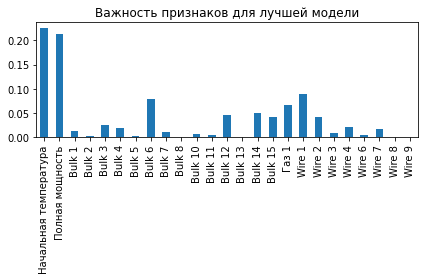

In [51]:
importances = best_model_rf.feature_importances_
forest_importances = pd.Series(importances, index=data_final.columns.drop(['Конечная температура']))
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Важность признаков для лучшей модели")
fig.tight_layout()

Наиболее важные признаки для модели - начальная температура и полная мощность, а также wire 1 и bulk 6. 

### Вывод

На данном этапе были обучены модели с помощью дерева решений, случайного леса, линейной регрессии и CatBoost, лучшие параметры подбирались при помощи RandomizedSearchCV. В итоге была выбрана лучшая модель - модель случайного леса с параметрами n_estimators=80, max_depth=16, результат MAE на тестовой выборке - 6.18. Модель была сравнена с константной моделью, был сделан вывод, что предсказания выбранной модели адекватны. Также был проведен анализ важности факторов, наиболее важные признаки для модели - начальная температура и полная мощность, а также wire 1 и bulk 6.

## Общий вывод

В ходе данной работы были проведены начальный обзор данных и их предобработка, а также исследовательский анализ данных:
* Был проведено исследование на наличие выбросов и аномалий таблиц с данными об электродах и результатами измерения температур, были обнаружены и удалены партии с сильными выбросами в реактивной мощности и температуре;
* Проведен анализ добавляемых материалов, из сыпучих материалов больше всего добавляются материалы bulk 12, bulk 14, bulk 15, меньше всего - bulk 8 и bulk 9, из проволочных материалов больше всего добавляется материал wire 1, меньше всего - wire 4-9;
* Было выяснено, как признаки коррелируют между собой. Была обнаружена очень высокая корреляция между полной мощностью и длительностью нагрева, а также между Bulk 9 и Wire 8, длительность нагрева и Bulk 9 были удалены из финальной таблицы. Также есть высокая корреляция между Wire 4 и Bulk 2 и между Wire 4 и Bulk 7 и средняя корреляция между Wire 4 и Wire 7, Bulk 15 и Bulk 12, Wire 6 и Bulk 2, Bulk 2 и Bulk 7. Между остальными признаками корреляция слабая, с целевым признаком все остальные признаки коррелируют очень слабо.

Затем были обучены модели дерева решений, случайного леса, линейной регрессии и CatBoost, была выбрана лучшая модель - модель случайного леса с параметрами n_estimators=80, max_depth=16, результат MAE на тестовой выборке - 6.18. Модель была сравнена с константной моделью, был сделан вывод, что предсказания выбранной модели адекватны. Также был проведен анализ важности факторов, наиболее важные признаки для модели - начальная температура и полная мощность, а также wire 1 и bulk 6.

## Отчет

Задачей данного проекта было помочь металлургическому комбинату ООО «Так закаляем сталь» оптимизировать производственные расходы за счет уменьшения потребления электроэнергии на этапе обработки стали. Цель данного проекта - построить модель, которая предскажет температуру стали.

В ходе решения данной задачи были выполнены следующие шаги:
* Был проведен начальный обзор предоставленных данных;
* Произведена предобработка данных: обработаны пропуски, данные приведены к верным типам, рассчитаны и добавлены новые признаки;
* Проведен исследовательский анализ данных, данные были проверены на наличие выбросов и аномальных значений, все важные для моделирования признаки были объединены в одной таблице, было исследовано, как признаки коррелируют между собой;
* Данные были разделены на обучающую и тестовую выборки, были обучены следующие модели: дерево решений, случайный лес, линейная регрессия, CatBoost;
* При помощи метрики MAE была выбрана лучшая модель, ее работа была проверена на тестовой выборке и была проверена адекватность ее предсказаний, а также для нее был проведен анализ важности признаков.

В итоге, все этапы составленного плана были выполнены. Проблемы в работе возникли в выборе верного способа обработки выбросов и аномалий, а также в выборе информативных признаков для моделирования, но более глубокое изучение задачи и методы визуализации помогли их преодолеть.

Ключевыми шагами в данной работе хочу назвать понимание процесса этапа обработки стали и на основании этого проведенные анализ и предобработку данных, а также моделирование и оценку качества работы моделей.

В результате решения данной задачи с помощью метрики MAE для достижения поставленной цели была выбрана модель случайного леса с параметрами n_estimators=80, max_depth=16, результат MAE на тестовой выборке - 6.18. Для выбранной модели был проведен анализ важности признаков, был построен следующий график:

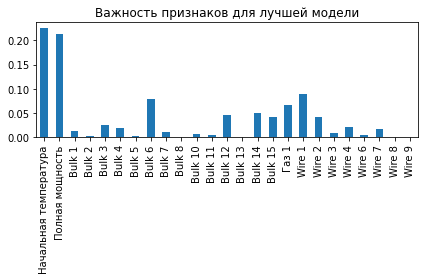

In [52]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Важность признаков для лучшей модели")
fig.tight_layout()

При помощи этого графика были выявлены наиболее важные признаки для модели - начальная температура и полная мощность, а также wire 1 и bulk 6. 